In [1]:
# setting device on GPU if available, else CPU
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')
if torch.cuda.device_count() > 1:
    print("Using ", torch.cuda.device_count(), "GPUs!")

Using device: cuda

TITAN Xp
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
Using  2 GPUs!


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import copy
import os
import random
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from glob import glob
import functools
from PIL import Image
import argparse
import os
import numpy as np
import random
import time
import datetime
import json
from pathlib import Path


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import transformers

In [4]:
from PIL import Image
from torchvision import transforms
from core.ofa import OFATokenizer, OFAModel
from core.ofa.generate import sequence_generator

In [5]:
from transformers import (
    HfArgumentParser,
    TrainingArguments,
)

In [6]:
from ctl.vqa_arguments import VQAArguments

In [11]:
from core.datasets.vqa_gen_dataset import VqaGenDataset , VQACollator, VqaDataset
from core.ofa.label_smoothed_cross_entropy import AdjustLabelSmoothedCrossEntropyCriterion
from core.ofa import OFATokenizer
from core.ofa.modeling_ofa import OFAModelForVQA
from core.ofa.configuration_ofa import OFAConfig
from accelerate import Accelerator
from accelerate.utils import DistributedDataParallelKwargs
from accelerate import DistributedType

In [8]:
import transformers

In [17]:
pretrained ='/coc/scratch/sanisetty3/DLM/OFA-tiny'
tokenizer_p = OFATokenizer.from_pretrained(pretrained)
model_p = OFAModelForVQA.from_pretrained(pretrained, use_cache=False)

/coc/scratch/sanisetty3/DLM/OFA-tiny
<super: <class 'OFATokenizer'>, <OFATokenizer object>>


/srv/share2/sanisetty3/miniconda3/envs/DLM/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


## Convert pt to pretrained bin

In [ ]:
pretrained ='/coc/scratch/sanisetty3/DLM/OFA-tiny'
fine_tuned ="/srv/scratch/sanisetty3/DLM/OFA_VQA/checkpoints/results/ofa_vqa.19000.pt"


In [ ]:
kwargs = DistributedDataParallelKwargs(find_unused_parameters = True)
accelerator = Accelerator(kwargs_handlers = [kwargs])

In [ ]:
fine_tuned ="/srv/scratch/sanisetty3/DLM/OFA_VQA/checkpoints/results/ofa_vqa.19000.pt"
pkg = torch.load(fine_tuned, map_location = 'cpu')

In [14]:
ofa_config = OFAConfig.from_pretrained('/coc/scratch/sanisetty3/DLM/OFA-tiny-fine-tune')
vqa_model = OFAModelForVQA(ofa_config)

In [21]:
unwrapped_model = accelerator.unwrap_model(vqa_model)

In [22]:
unwrapped_model.load_state_dict(pkg['model'])

In [16]:
unwrapped_model.save_pretrained('/coc/scratch/sanisetty3/DLM/OFA-tiny-fine-tune/', save_function=accelerator.save)

## Test VQAv2

In [39]:
tokenizer_p = OFATokenizer.from_pretrained(pretrained)


/coc/scratch/sanisetty3/DLM/OFA-tiny
<super: <class 'OFATokenizer'>, <OFATokenizer object>>


In [40]:
model_p = OFAModelForVQA.from_pretrained(pretrained, use_cache=False)
model_f = OFAModelForVQA.from_pretrained(fine_tuned, use_cache=False)

In [41]:
mean, std = [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]
resolution = 480

patch_resize_transform = transforms.Compose([
    lambda image: image.convert("RGB"),
    transforms.Resize((resolution, resolution), interpolation=Image.BICUBIC),
    transforms.ToTensor(), 
    transforms.Normalize(mean=mean, std=std)
])

In [42]:
ann_file = os.path.join('/srv/scratch/sanisetty3/DLM/AliceMind/mPLUG/data/json/vqa_ocr_object/' ,"vqa_train_ocr.json")
vqa_root = '/srv/datasets/coco/'


In [43]:
ds = VqaDataset(
    ann_file=[ann_file],
    vqa_root=vqa_root,
)
data_collator = VQACollator(tokenizer=tokenizer_p, max_seq_length=128)
dl = DataLoader(ds, batch_size = 8, collate_fn=data_collator ,num_workers = 0, shuffle = True)


In [44]:
for batch in dl:
    break

In [45]:
print(tokenizer_p.batch_decode(batch["input_ids"], skip_special_tokens=True))

[' does the woman have anything to drink?', ' how many sheep are in this photo?', ' is the man wearing a tie?', ' is union square bank really square?', ' what is the subject of the photo?', ' how many computer screens are on?', ' is the man wearing pants?', ' is this a large crowd?']


In [46]:
print(tokenizer_p.batch_decode(batch["target"], skip_special_tokens=True))

['no', '2', 'no', 'yes', 'kitchen', '4', 'no', 'yes']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


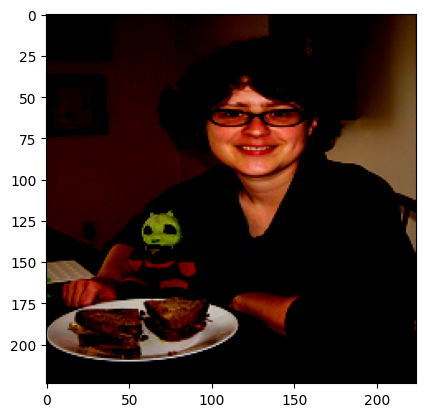

In [47]:
plt.imshow(batch["patch_images"][0].permute(1,2,0).cpu().numpy())

In [55]:
print(tokenizer_p.batch_decode(batch["target"], skip_special_tokens=True))

['no', '2', 'no', 'yes', 'kitchen', '4', 'no', 'yes']


### Pretrained

In [ ]:
indx = 1

In [48]:
gen = model_p.generate(batch["input_ids"], patch_images=batch["patch_images"], num_beams=5, no_repeat_ngram_size=3)

In [54]:
tokenizer_p.batch_decode(gen, skip_special_tokens=True)

[' no', ' 2', ' no', ' no', ' the kitchen', ' 2', ' yes', ' yes']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


no


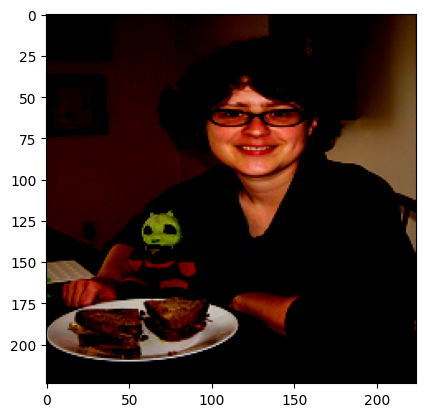

In [49]:
plt.imshow(batch["patch_images"][indx].permute(1,2,0).cpu().numpy())
print(tokenizer_p.batch_decode(gen, skip_special_tokens=True)[indx].strip())

### Finetuned

In [51]:
gen_fin = model_f.generate(batch["input_ids"], patch_images=batch["patch_images"], num_beams=5, no_repeat_ngram_size=3)

In [53]:
tokenizer_p.batch_decode(gen_fin, skip_special_tokens=True)

['no', '0', 'no', 'yes', 'kitchen', '2', 'no', 'yes']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


no


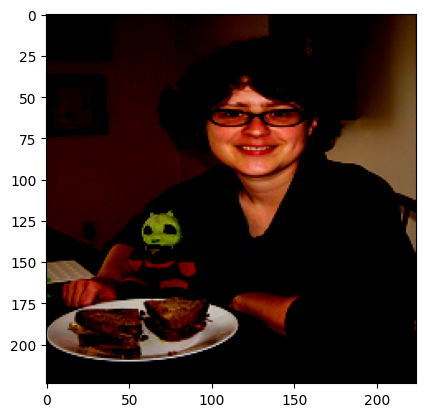

In [52]:
plt.imshow(batch["patch_images"][indx].permute(1,2,0).cpu().numpy())
print(tokenizer_p.batch_decode(gen_fin, skip_special_tokens=True)[indx].strip())

## Custom image and question

In [56]:
pretrained ='/coc/scratch/sanisetty3/DLM/OFA-huge-vqa'
fine_tuned ="/srv/scratch/sanisetty3/DLM/OFA-tiny-fine-tune/"


In [57]:
tokenizer_p = OFATokenizer.from_pretrained(pretrained)
model_p = OFAModelForVQA.from_pretrained(pretrained, use_cache=False)

/coc/scratch/sanisetty3/DLM/OFA-huge-vqa
<super: <class 'OFATokenizer'>, <OFATokenizer object>>


In [31]:
model_f = OFAModelForVQA.from_pretrained(fine_tuned, use_cache=False)

In [32]:
mean, std = [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]
resolution = 480

patch_resize_transform = transforms.Compose([
    lambda image: image.convert("RGB"),
    transforms.Resize((resolution, resolution), interpolation=Image.BICUBIC),
    transforms.ToTensor(), 
    transforms.Normalize(mean=mean, std=std)
])

/srv/share2/sanisetty3/miniconda3/envs/DLM/lib/python3.9/site-packages/torchvision/transforms/transforms.py:329: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


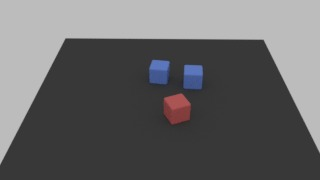

In [58]:
txt = "How many blocks are there?"
inputs = tokenizer_p([txt], return_tensors="pt").input_ids
img = Image.open('./samples/i1.jpeg')
patch_img = patch_resize_transform(img).unsqueeze(0)
img

### Pretrained

In [59]:
custom_gen = model_p.generate(inputs, patch_images=patch_img, num_beams=5, no_repeat_ngram_size=3)

/srv/share2/sanisetty3/miniconda3/envs/DLM/lib/python3.9/site-packages/transformers/generation/utils.py:1273: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 20 (`generation_config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


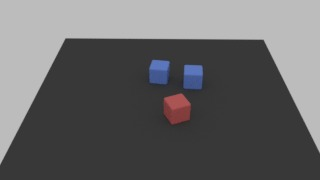

5


In [60]:
display(img)
print(tokenizer_p.batch_decode(custom_gen, skip_special_tokens=True)[0].strip())

### Fine tuned

In [36]:
custom_gen_fin = model_f.generate(inputs, patch_images=patch_img, num_beams=5, no_repeat_ngram_size=3)

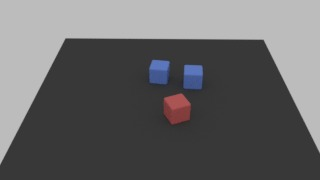

1


In [37]:
display(img)
print(tokenizer_p.batch_decode(custom_gen_fin, skip_special_tokens=True)[0].strip())